# Neural Network Force-Free magnetic field extrapolation - NF2
<img src="https://github.com/RobertJaro/NF2/blob/main/images/logo.jpg?raw=true" width="150" height="150">

This notebook uses NF2 to download and extrapolate vector magnetograms from SDO/HMI. Active regions and dates can be selected below.

We use NF2 to extrapolate a time-series and to analyze the resulting magnetic energy build-up and release processes (e.g., flares).

GitHub Page: https://github.com/RobertJaro/NF2


**Use**: A python notebook consists of code cells and embedded text descriptions. If you are using Google Colab all computations and installations are performed online, using free resources. You can execute the notebook cell-by-cell (hit `shift`+`return`), or run the full notebook by selecting `Runtime` --> `Run all` from the menu. Use the forms below to select the active region, date, and training parameters. For regular use you can keep the default training parameters.

## Installation and Imports

NF2 can be directly installed from the GitHub repository.

In [ ]:
# !pip install git+https://github.com/RobertJaro/NF2.git

In [1]:
# general imports
import glob
import os
from datetime import datetime, timedelta
from dateutil.parser import parse
import shutil
import gdown

# download
import drms
from urllib import request

# data processing
import numpy as np
from sunpy.map import Map
from sunpy.net import Fido
from sunpy.net import attrs as a

# deep learning
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LambdaCallback
import wandb

# NF2
from nf2.train.module import NF2Module, save
from nf2.train.data_loader import SHARPDataModule, SHARPSeriesDataModule
from nf2.data.download import download_HARP_series, find_HARP, download_euv
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.metric import *
from nf2.evaluation.energy import get_free_mag_energy
from nf2.evaluation.series import evaluate_nf2_series
from nf2.evaluation.flares import _calculate_free_energy, get_integrated_euv_map, load_B_map

# visualization
from matplotlib import pyplot as plt

## Data download

We start by downloading a series of SDO/HMI vector magnetograms. Use the forms below to set your email, and specify the active region that you are interested in (SHARP + date).

Downloading data requires an active registration at JSOC. http://jsoc.stanford.edu/ajax/register_email.html

In [2]:
#@title Download Credentials
jsoc_email = 'mgjeon@khu.ac.kr' #@param {type:"string"}

In [3]:
client = drms.Client(email=jsoc_email, verbose=True)

If you are looking for a NOAA active region, you can use the function below to search for the corrsponding HARP number.

In [4]:
#@title Start date of observation series
year = 2017 #@param {type:"integer"}
month = 9 #@param {type:"integer"}
day = 6 #@param {type:"integer"}
hour = 8 #@param {type:"integer"}
minute = 36 #@param {type:"number"}

date = datetime(year, month, day, hour, minute)

In [5]:
#@title Find SHARP number for given NOAA
noaa_nums = [12673] #@param {type:""}

find_HARP(date, noaa_nums, client)

7115

In [6]:
#@title Active Region
#@markdown (add the number from above here)
sharp_nr = 7115 #@param {type:"number"}
duration = '3h' # @param {type:"string"}

date = datetime(year, month, day, hour, minute)

download_dir = 'AR_7115' #@param {type:"string"}


Start download for time-series.

In [7]:
# download_HARP_series(sharp_nr, date, duration, download_dir, client)

Let's check the first map in the series.

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


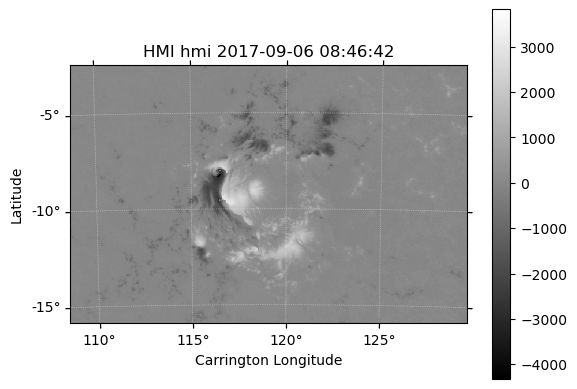

In [8]:
Map(glob.glob(os.path.join(download_dir, '*Br.fits'))[0]).peek()

## Set parameters

In [9]:
#@title Paths
base_path = None #@param {type:"string"}
base_path = 'ar_%d_%s' % (sharp_nr, date.isoformat('T')) if base_path is None else base_path
data_path = None #@param {type:"string"}
data_path = download_dir if data_path is None else data_path

os.makedirs(base_path, exist_ok=True)

save_path = os.path.join(base_path, 'extrapolation_result.nf2')

In [10]:
#@title Data Parameters
bin = 2 #@param {type:"integer"}
spatial_norm = 160  #@param {type:"integer"}
height = 160  #@param {type:"integer"}
b_norm = 2500  #@param {type:"number"}
d_slice =  None#@param {type:"raw"}
potential_boundary = True #@param {type:"boolean"}


boundary = {'type': 'potential', 'strides': 4} if potential_boundary else {'type': 'open'}

data_args = {"data_path": data_path,
             "height":height,
             "spatial_norm": spatial_norm,
             "b_norm": b_norm,
             "work_directory": base_path,
             "bin": bin,
             "Mm_per_pixel": 0.72,
             "slice": d_slice,
             "boundar": boundary
             }

In [11]:
#@title Model Parameters
#@markdown `dim = 64` &rarr; tiny

#@markdown `dim = 256` &rarr; regular

dim = 256 #@param {type:"number"}
vector_potential = False #@param {type:"boolean"}

model_args = {"dim": dim, "use_vector_potential": vector_potential}

In [12]:
#@title Training Parameters
lambda_div = 0.1 #@param {type:"number"}
lambda_ff = 0.1 #@param {type:"number"}

iterations = 8e4 #@param {type:"number"}
iterations = int(iterations)

validation_interval = 1e4 #@param {type:"number"}
validation_interval = int(validation_interval)


batch_size = 1e4 #@param {type:"number"}
batch_size = int(batch_size)

data_args['iterations'] = iterations
data_args['batch_size'] = batch_size
training_args = {"lambda_div": lambda_div,
              "lambda_ff": lambda_ff,}
# combine args
config = {'data': data_args, 'model': model_args, 'training': training_args}

## Training - Extrapolation

Initialize the Weights and Biases (wandb) logger. The training results will be automatically uploaded during training and model checkpoints can be used to continue the model training.

In [ ]:
wandb_logger = WandbLogger(project='nf2', name=str(sharp_nr), dir=base_path, log_model="all")
wandb_logger.experiment.config.update(config, allow_val_change=True)

In [14]:
#@title Continue training from WandB
#@markdown Enter your credentials if you want to continue an inturrpted run. This will restore the latest model and continue the training.
wandb_id = "leulgqtq" #@param {type:"string"}
wandb_entity = "mgjeon" #@param {type:"string"}
wandb_project = "nf2" #@param {type:"string"}
if wandb_id != "" and wandb_id is not None:
    checkpoint_reference = f"{wandb_entity}/{wandb_project}/model-{wandb_id}:latest"
    artifact = wandb_logger.use_artifact(checkpoint_reference, artifact_type="model")
    artifact.download(root=base_path)
    shutil.move(os.path.join(base_path, 'model.ckpt'), os.path.join(base_path, 'last.ckpt'))
    data_args['plot_overview'] = False  # skip overview plot for restored model

wandb:   1 of 1 files downloaded.  


For logging we use WandB which allows us to monitor the traing process and saves our results.

Before we start the extrapolation we need to process the downloaded data. The model requires the vector magnetogram and the corresponding error map. For this we use a data loader that automatically handles the processing of SHARPS according to the parameters set above.

In [15]:
data_module = SHARPDataModule(**data_args)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


We initialize the NF2 model with the parameters from above.

In [16]:
validation_settings = {'cube_shape': data_module.cube_dataset.coords_shape,
                       'gauss_per_dB': b_norm,
                       'Mm_per_ds': data_module.Mm_per_pixel * spatial_norm}

nf2 = NF2Module(validation_settings, **model_args, **training_args)

During training we log model states with callbacks that are used after every validation step. The models are then automatically synched to wandb. The extrapolation result (`.nf2` file) can be found in the file explorer on the left.

In [17]:
save_callback = LambdaCallback(
    on_validation_end=lambda *args: save(save_path, nf2.model, data_module, config, nf2.height_mapping_model))
checkpoint_callback = ModelCheckpoint(dirpath=base_path,
                                      every_n_train_steps=validation_interval,
                                      save_last=True)

We initiliaze the traininer from pytorch lightning which handles the individual components.

In [ ]:
n_gpus = torch.cuda.device_count()
trainer = Trainer(max_epochs=1,
                  logger=wandb_logger,
                  devices=n_gpus if n_gpus >= 1 else None,
                  accelerator='gpu' if n_gpus >= 1 else None,
                  strategy='dp' if n_gpus > 1 else None,
                  num_sanity_val_steps=0,
                  val_check_interval=validation_interval,
                  gradient_clip_val=0.1,
                  callbacks=[checkpoint_callback, save_callback], )

Now we can start our model training. The training progress is automatically logged to wandb. Follow the link above to see the status and intermediate results.

In [ ]:
trainer.fit(nf2, data_module, ckpt_path='last')

As last step we save the trained model. If you continue an interrupted training run, excecude the code below to restore the nf2 file.

In [20]:
save(save_path, nf2.model, data_module, config, nf2.height_mapping_model)

## Evaluation

If you want to skip the training you can use the line below to download an example solution.

In [22]:
#@title Download sample extrapolation result
download = False #@param {type:"boolean"}
tiny = False #@param {type:"boolean"}
if download:
  if tiny:
    gdown.download('https://drive.google.com/uc?id=1BwvEtsw10pE18RDfSPnCKy3476FqV47_', save_path)
  else:
    gdown.download('https://drive.google.com/uc?id=1m57uDWSOiTd0cYUpZGr7nQ5HO00iTePl', save_path)

It is important that the resutls are checked after the extrapolation is finished. The NF2 package provides metrics that can be used to estimate the quality. Both the divergence and the angle between the currents and magnetic field should be small. (ideally mean divergence `<0.1` and sigma `<10` degree; the exact values depend on the selected active region and lambda weights)

From the save file we can load the full simulation volume.

In [23]:
b = load_cube(save_path, progress=True)

100%|██████████| 12329/12329 [00:08<00:00, 1429.68it/s]


The loaded mesh can be used to compute the divergence and the sigma angle.

In [24]:
n_div = (np.abs(divergence(b)) / vector_norm(b)).mean()
theta = weighted_theta(b)

print('DIVERGENCE [1/pix]: %.04f; THETA [deg] %.04f' % (n_div, theta))

DIVERGENCE [1/pix]: 0.0077; THETA [deg] 18.1219


We can also compute maps of integrated current density.

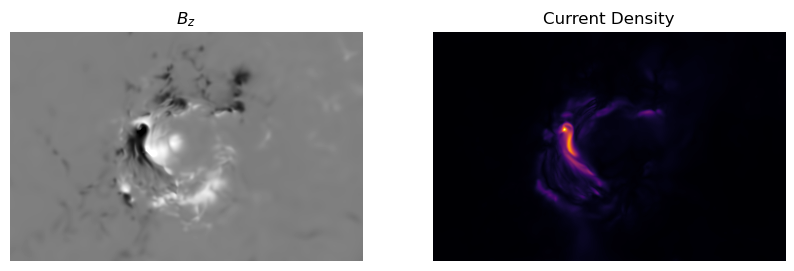

In [26]:
j = curl(b)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(b[:, :, 0, 2].T, vmin=-2500, vmax=2500, origin='lower', cmap='gray')
plt.title('$B_z$')
plt.axis('off')
plt.subplot(122)
plt.imshow(vector_norm(j).sum(2).T, origin='lower', cmap='inferno')
plt.title('Current Density')
plt.axis('off')
plt.show()

By computing the potential field we can estimate the free magnetic energy, and visualize the result as integrated map. Here, we only consider the first 64 grid cells in height for faster computation.

Potential Field: 100%|██████████| 4932/4932 [01:35<00:00, 51.52it/s]


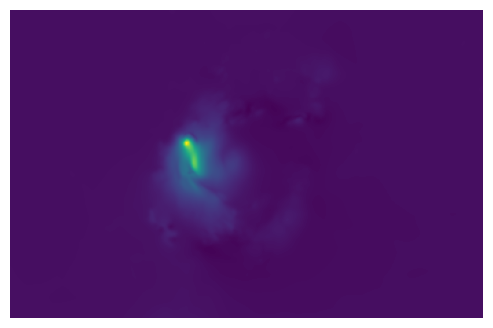

In [27]:
free_me = get_free_mag_energy(b[:, :, :64])
plt.figure(figsize=(8,4))
plt.imshow(free_me.sum(2).transpose(), origin='lower')
plt.axis('off')
plt.show()

## Export

VTK files can be used to visualize the extrapolation results (e.g., Paraview). We use `tvtk` for converting the files.
The NF2 results require little storage (about 2 MB). It is faster to download the NF2 file and convert it on your local environment using the CPU resources.

The code below can be used to convert files in Colab.

In [28]:
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.vtk import save_vtk

In [29]:
model_path = base_path + '/extrapolation_result.nf2'
vtk_path = base_path + '/extrapolation_result.vtk'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
b = load_cube(model_path, device, progress=True)
save_vtk(b, vtk_path, 'B')

100%|██████████| 12329/12329 [00:09<00:00, 1345.76it/s]


## Training - Series Extrapolation

Starting from our previous extrapolation, we can significantly speed-up the extrapolation of the temporal evolution. For this we adapt the model sequentially by changing the boundary condition and re-training the model. This allows us to converge within few iterations per time step.

We start by downloading the data. Fill the form below to select your time range. Note that we use the same start point and sharp as in the previous extrapolation (i.e., we require an initial extrapolation).

To skip the initial training you can download the pre-trained state by running the code below.

In [30]:
#@title Series parameters
step_iterations = 2e3 #@param {type:"number"}
check_val_every_n_epoch =  100 #@param {type:"integer"}

series_data_args = {**data_args}
series_data_args['iterations'] = int(step_iterations)
del series_data_args['data_path']

series_training_args = {**training_args}
series_training_args['lambda_b'] = 1
series_training_args['lr_params'] = 5e-4

Initialize the logging to wandb.

In [ ]:
wandb.finish()
wandb_logger = WandbLogger(project='nf2', name=str(sharp_nr) + '_series', dir=base_path, log_model="all")
wandb_logger.experiment.config.update(config, allow_val_change=True)

We prepare the data loader which will sequentially update the boundary condtion of the magnetic field extrapolation.

In [32]:
hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z
err_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp_err.fits')))  # x
err_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt_err.fits')))  # y
err_r_files = sorted(glob.glob(os.path.join(data_path, '*Br_err.fits')))  # z

data_paths = list(zip(hmi_p_files, err_p_files, hmi_t_files, err_t_files, hmi_r_files, err_r_files))
data_module = SHARPSeriesDataModule(data_paths, **series_data_args)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


We re-initialize the model and use the previous model as initial starting point (`meta_path`)

In [33]:
nf2 = NF2Module(validation_settings, meta_path=save_path, **model_args, **series_training_args)

Model checkpoints are saved every epoch before we update the boundary condition. The resulting nf2 files correspond then to the frames of the series.

In [34]:
save_callback = LambdaCallback(on_train_epoch_end=lambda *args: save(
    os.path.join(base_path, os.path.basename(data_paths[nf2.current_epoch][0]).split('.')[-3] + '.nf2'),
    nf2.model, data_module, config, nf2.height_mapping_model))

In [ ]:
trainer = Trainer(max_epochs=len(data_paths),
                  logger=wandb_logger,
                  devices=n_gpus if n_gpus >= 1 else None,
                  accelerator='gpu' if n_gpus >= 1 else None,
                  strategy='dp' if n_gpus > 1 else None,
                  num_sanity_val_steps=0, callbacks=[save_callback],
                  gradient_clip_val=0.1, reload_dataloaders_every_n_epochs=1,
                  check_val_every_n_epoch=check_val_every_n_epoch)

In [ ]:
trainer.fit(nf2, data_module)

## Evaluation  - Series

In [38]:
#@title Download sample extrapolation result
download = False #@param {type:"boolean"}
if download:
  zip_path = os.path.join(base_path, 'nf2_series.zip')
  gdown.download('https://drive.google.com/uc?id=1lkbPC7r8EiIrNp_h14Dj_DUKzwpkR60x', zip_path)
  shutil.unpack_archive(zip_path, base_path)

In [ ]:
nf2_files = sorted(glob.glob(os.path.join(base_path, '*.nf2')))
nf2_files = [f for f in nf2_files if 'extrapolation_result.nf2' not in f] # filter the initial state

state = torch.load(nf2_files[0], map_location='cpu')
Mm_per_pix = state['Mm_per_pixel']
cm_per_pix = (Mm_per_pix * 1e8)
z_pixels = int(np.ceil(20 / (Mm_per_pix)))

series_results = evaluate_nf2_series(nf2_files, z_pixels, cm_per_pix, 2, batch_size)

Registered flares in this sequence: X2.2 - 08:57; C5.4 - 10:13; X9.3 - 11:53

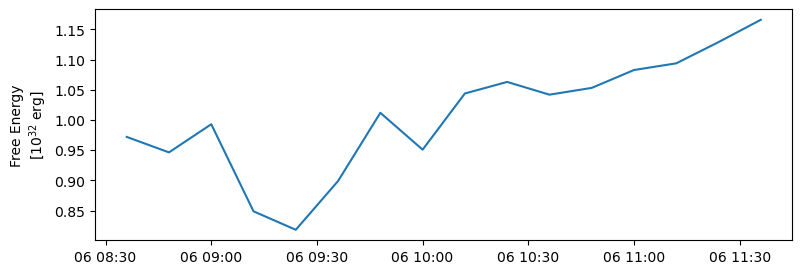

In [40]:
# plot the integrated free magnetic energy
plt.figure(figsize=(9, 3))
plt.plot(series_results['date'], np.array(series_results['total_free_energy']) * 1e-32)
plt.ylabel('Free Energy\n[$10^{32}$ erg]')
plt.show()

## Evaluate Flare Event

The magnetic field extrapolations can be used to compare the energy change to flare events and locate regions of strong energy release.

We use `Fido` to find registered flares in our series.

In [41]:
dates = [parse(os.path.basename(nf2_file).split('.')[0][:-4].replace('_', 'T')) for nf2_file in nf2_files]
flares = Fido.search(a.Time(min(dates), max(dates)),
                     a.hek.EventType("FL"),
                     a.hek.OBS.Observatory == "GOES")["hek"]
#flares = [f for f in flares if f["fl_goescls"][0] in ['M', 'X']]

In [42]:
flares[['event_starttime', 'fl_goescls']]

event_starttime,fl_goescls
Time,str4
2017-09-06 08:57:00.000,X2.2


Use the list above to select the flare event you are interested in.

In [44]:
flare = list(flares)[0] # select flare

We download EUV observations as reference for comparison.

In [ ]:
start_time = flare["event_starttime"].datetime
end_time = flare["event_endtime"].datetime
euv_files = download_euv(start_time, end_time, download_dir, client=client)

In [58]:
filter_dates = (np.array(dates) > (start_time - timedelta(minutes=12))) & \
                (np.array(dates) < (end_time + timedelta(minutes=12)))
flare_nf2_files = np.array(nf2_files)[filter_dates]

In [ ]:
free_energy_0 = _calculate_free_energy(flare_nf2_files[0], z_pixels, batch_size)
free_energy_1 = _calculate_free_energy(flare_nf2_files[-1], z_pixels, batch_size)

In [ ]:
released_energy = -np.clip(free_energy_0 - free_energy_1, a_min=None, a_max=0)
released_energy_map = released_energy.sum(2) * cm_per_pix

In [51]:
mag_map = load_B_map(flare_nf2_files[0])

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


In [53]:
from multiprocessing import Pool
class _F:
    def __init__(self, ref_wcs):
        self.ref_wcs = ref_wcs

    def func(self, file):
        return Map(file).reproject_to(self.ref_wcs)

In [54]:
def get_integrated_euv_map(euv_files, ref_wcs):
    with Pool(os.cpu_count()) as p:
        reprojected_maps = p.map(_F(ref_wcs).func, euv_files)
    integrated_euv = np.array([m.data for m in reprojected_maps]).sum(0)
    euv_map = Map(integrated_euv, mag_map.meta)
    return euv_map

In [55]:
euv_map = get_integrated_euv_map(euv_files, mag_map.wcs)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


In [56]:
from astropy.visualization import ImageNormalize, AsinhStretch

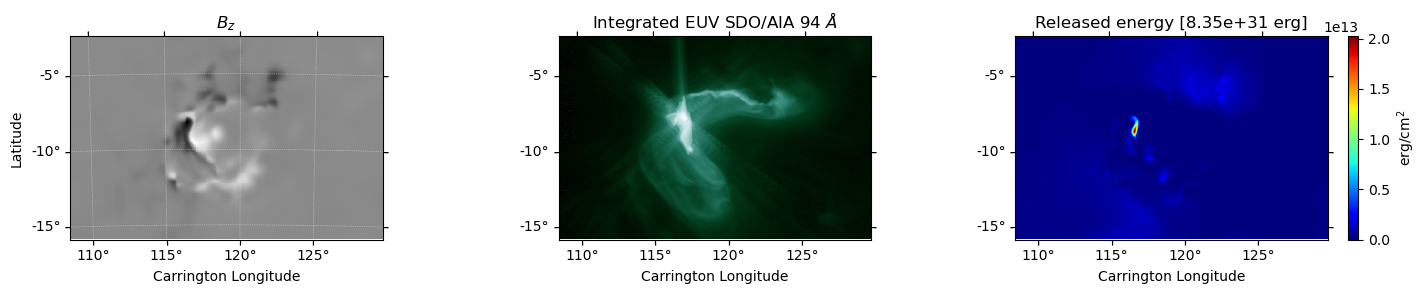

In [57]:
plt.figure(figsize=(15, 3))

plt.subplot(131, projection=mag_map)
mag_map.plot()
plt.title('$B_z$')

plt.subplot(132, projection=euv_map)
plt.imshow(euv_map.data, origin='lower', cmap='sdoaia94', norm=ImageNormalize(stretch=AsinhStretch(0.005)))
plt.title('Integrated EUV SDO/AIA 94 $\AA$')
plt.xlabel('Carrington Longitude')
plt.ylabel(' ')

plt.subplot(133, projection=mag_map)
im = plt.imshow(released_energy_map.T, origin='lower', cmap='jet')
plt.title(f'Released energy [{released_energy.sum() * cm_per_pix ** 3:.2e} erg]')
plt.xlabel('Carrington Longitude')
plt.ylabel(' ')
plt.colorbar(mappable=im, label='erg/cm$^2$')

plt.tight_layout()
plt.show()
plt.close()